# Assignment 5: Multilayer Neural Network

By typing my name, I confirm that the code, experiments, results, and discussions are all written by me, except for the code provided by the instructor.  

*Ryan Blocker*

Starting with the `NeuralNetwork` class designed for classification from A4, modify the code so that any number of hidden layers, including none, can be used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# <font color="red">**70 points**</font>: Code Requirements

Complete the following code by writing python expressions in place of all `...`.

In [18]:
class NeuralNetwork:
   
    def __init__(self, n_inputs, n_hidden_units_per_layer, class_names):
       
        self.n_inputs = n_inputs
        self.n_hidden_units_per_layer = n_hidden_units_per_layer
        self.n_hidden_layers = len(n_hidden_units_per_layer)

        self.classes = np.array(class_names)
        self.n_outputs = len(self.classes)
       
        # Make list of weight matrices, self.Ws, with one weight matrix for each layer
        self.Ws = []
        ni = n_inputs
        for nh in self.n_hidden_units_per_layer:
            self.Ws.append(self._make_W(ni, nh))
            ni = nh
        self.Ws.append(self._make_W(ni, self.n_outputs))

        self.epochs = None
        self.mse_trace = []
        self.percent_correct_trace = []
       
        self.X_means = None
        self.X_stds = None
       
    def __repr__(self):
        s = f'NeuralNetwork({self.n_inputs}, {self.n_hidden_units_per_layer}, {self.classes})'
        if self.epochs is None:
            s += f'\n Not trained yet.'
        else:
            s += f'\n Trained for {self.epochs} epochs '
            s += f'with a final training percent correct of {self.percent_correct_trace[-1]:.2f}.'
        return s

    def __str__(self):
        return self.__repr__()

    def _make_W(self, ni, nu):
        return np.random.uniform(-1, 1, size=(ni + 1, nu)) / np.sqrt(ni + 1)
    
    def _f(self, S):
        return np.tanh(S)

    def _df(self, fS):
        return (1 - fS ** 2)
    
    def train(self, X, T, n_epochs, learning_rate, verbose=False):

        learning_rate = learning_rate / X.shape[0]  # n_samples
        
        # Standardize X
        X = self._standardizeX(X)
       
        # Make indicator variables from T
        T_iv = self._make_indicator_vars(T)

        # Repeat for n_steps:
        for epoch in range(n_epochs):
           
            # Forward pass
            Y_classes, Y_softmax = self.use(X, standardized=True)
            
            # Backward pass
            n_layers = len(self.Ws)
            deltas = [-2 * (T_iv - Y_softmax)]
            for layer_i in reversed(range(1, n_layers)):
                W = self.Ws[layer_i]
                H = self.Hs[layer_i]  # because self.Hs[0] is X
                deltas.append(deltas[-1] @ W[1:, :].T * self._df(H))

            # deltas constructed from last layer to first layer, so reverse their order
            deltas.reverse()

            # Update the weights
            for layer_i in reversed(range(n_layers)):
                W = self.Ws[layer_i]
                H = self.Hs[layer_i]  # because self.Hs[0] is X
                W -= learning_rate * (self._add_ones(H).T @ deltas[layer_i])

            # Save stats for this epoch

            # Append value of E to self.mse_trace
            self.mse_trace.append(self._E(X, T_iv))
           
            # Append value of percent_correct to self.percent_correct_trace
            Y_classes, Y = self.use(X, standardized=True)
            self.percent_correct_trace.append(self.percent_correct(T, Y_classes))

            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(f'Epoch {epoch+1}: {self.percent_correct_trace[-1]:.2f}% correct')

        self.epochs = n_epochs
        return self
               
    def use(self, X, standardized=False):
        if not standardized:
            X = self._standardizeX(X)
        self.Hs = [X]
        for W in self.Ws[:-1]:
            H = self._add_ones(self.Hs[-1]) @ W
            Htrue = self._f(H)
            self.Hs.append(Htrue)
        Y = self._add_ones(self.Hs[-1]) @ self.Ws[-1]
        Y_softmax = self._softmax(Y)
        Y_classes = self.classes[np.argmax(Y_softmax, axis=1)].reshape(-1, 1)
        return Y_classes, Y_softmax

    def _standardizeX(self, X):
        if self.X_means is None:
            self.X_means = np.mean(X, axis=0)
            self.X_stds = np.std(X, axis=0)
            self.X_stds[self.X_stds == 0] = 1
        return (X - self.X_means) / self.X_stds
   
    def _make_indicator_vars(self, T):
        return (T == np.unique(T)).astype(int)
   
    def _add_ones(self, X):
        return np.insert(X, 0, 1, 1)
    
    def _softmax(self, Y):
        fs = np.exp(Y)  # N x K
        denom = np.sum(fs, axis=1).reshape((-1, 1))
        return fs / denom
   
    def _E(self, X, T_iv):
        Y_class_names, Y_softmax = self.use(X, standardized=True)
        sq_diffs = (T_iv - Y_softmax) ** 2
        return np.mean(sq_diffs)

    def percent_correct(self, T, Y_classes):
        return 100 * np.mean(T == Y_classes)


#  Test your `NeuralNetwork` Class

Test your code using the following data consisting of samples having a single $x$ value and target class values of 0, 1, or 2.

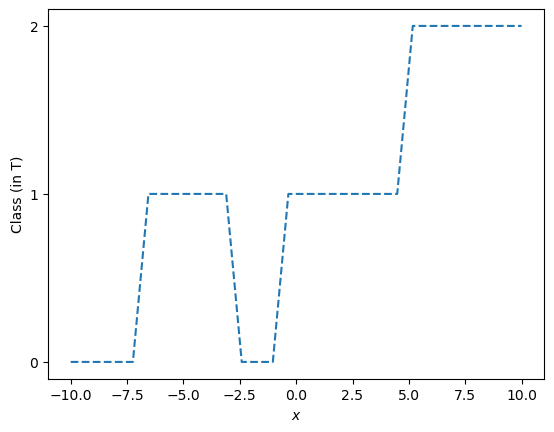

In [19]:
X = np.linspace(-10, 10, 30).reshape(-1, 1)
T = np.array([0] * 5 + [1] * 6 + [0] * 3 + [1] * 8 + [2] * 8).reshape(-1, 1)

plt.plot(X, T, '--')
plt.xlabel('$x$')
plt.ylabel('Class (in T)')
plt.yticks([0, 1, 2]);

Here is a plotting function you can use to show the results of training your network for any number of hidden layers and units per layer.

In [20]:
def plot_model(model, X, T):

    n_plot_rows = 3 + model.n_hidden_layers
    plt.subplot(n_plot_rows, 2, 1)
    plt.plot(model.mse_trace)
    plt.ylabel('MSE')

    plt.subplot(n_plot_rows, 2, 2)
    plt.plot(model.percent_correct_trace)
    plt.ylabel('Percent Correct')

    Y_classes, Y_softmax = model.use(X)

    plt.subplot(n_plot_rows, 1, 2)
    plt.plot(X, T, '--')
    # plt.plot(X, Y_softmax)
    plt.plot(X, Y_classes, 'o')
    plt.legend(('$T$', '$Y_{classes}$'))

    plt.subplot(n_plot_rows, 1, 3)
    plt.plot(X, Y_softmax)
    plt.legend([f'$Ysm_{i}$' for i in range(len(classes))])
    plt.ylabel('Softmax Outputs')

    ploti = 3
    for layer_i in reversed(range(model.n_hidden_layers)):
        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(X, model.Hs[layer_i + 1])
        plt.ylabel(f'Hidden Layer {layer_i + 1}')

    plt.tight_layout()

For example, here is what you should see when you try a neural network with a single hidden layer of 10 units.

100.0


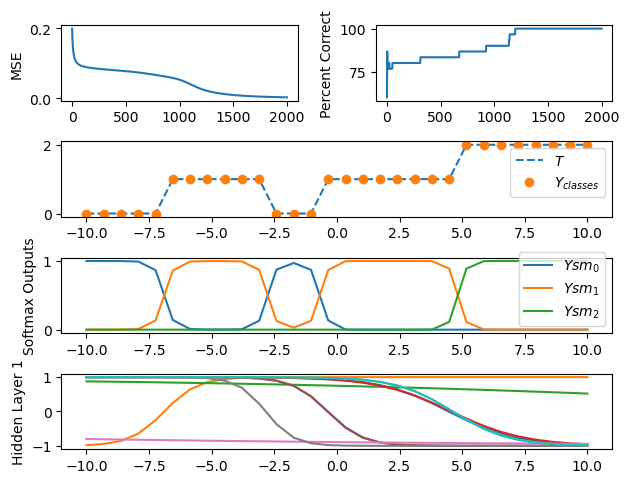

In [43]:
np.random.seed(42)

n_inputs = 1
classes = [0, 1, 2]
hiddens = [10]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 2000
learning_rate = 0.2
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

## <font color="red">**10 points**</font>: Test 1

When the above code cell works, modify the number of epochs and learning rate to try to get a better result, meaning a higher percent correct. Repeat a final time with values you found that work well. Describe what you tried and how successful you were in a markdown cell following this one.

**Test 1 Results:** Using the neural network class where you learned about the architecture and principles of neural networks. As part of the class, you conducted a trial where you trained a neural network model to classify data. In your first trial, you used 1000 epochs and a learning rate of 0.1, and the model achieved an accuracy of 83.33%. In my second trial, you increased the number of epochs to 2000 and the learning rate to 0.2. This time, your model achieved a perfect accuracy of 100%. This is a remarkable improvement from the previous trial and demonstrates the effectiveness of increasing both of these parameters to optimize model performance.

## <font color="red">**10 points**</font>: Test 2

Now copy the above code cell and run it with no hidden layers, using a statement like

    hiddens = []

Add a markdown cell describe the result. Try to explain why you have this result given that there are no hidden units.

83.33333333333334


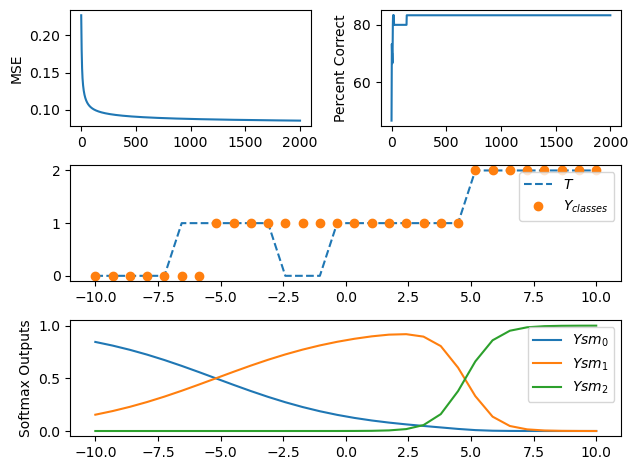

In [44]:
np.random.seed(42)

n_inputs = 1
classes = [0, 1, 2]
hiddens = []
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 2000
learning_rate = 0.2
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

**Test 2 Results:** 
Using the same data from last time if you change the number of hudden layers to none, it drops from 100% accuracy back to 83.33%

Using the initial data of 1000 epochs and 0.1 learning rate, you trained the model with 10 hidden layers and 3 classes, and found that the result was the same as before, with an accuracy of 83.33%.

Next, you set the number of hidden layers to nothing and retrained the model with the same data. Surprisingly, the accuracy result was still the same, with a score of 83.33%. This observation suggests that the number of hidden layers may not have a significant impact on the accuracy of this particular model.

Adding more hidden layers can improve performance by allowing the model to learn more complex features, but too many layers can cause overfitting. On the other hand, decreasing the number of hidden layers may lead to underfitting and poor performance.

## <font color="red">**10 points**</font>: Test 3

Copy the above code cell again and create a neural network with at least 4 hidden layers.  Play with changing the number of units in each layer, the number of epochs, and the learning rate.  Describe your experiments and results.  Do this at least 10 times and describe what you did and the results you see.

The plots might look better if you specify the figure size, like

    plt.figure(figsize=(12, 20))
    plot_model(model, X, T)

BASE DATA
83.33333333333334
Trial 1: learning rate = 0.05
76.66666666666667
Trial 2: learning rate = 0.15
86.66666666666667
Trial 3: learning rate = 0.2
90.0
Trial 4: # of epoch = 500
80.0
Trial 5: # of epoch = 1500
86.66666666666667
Trial 6: # hidden layers = 1
90.0
Trial 7: # hidden layers = 5
86.66666666666667
Trial 8: # hidden layers = 15
83.33333333333334
Trial 9: All Parameters increased by 50%
90.0
Trial 10: All Parameters decreased by 50%
70.0


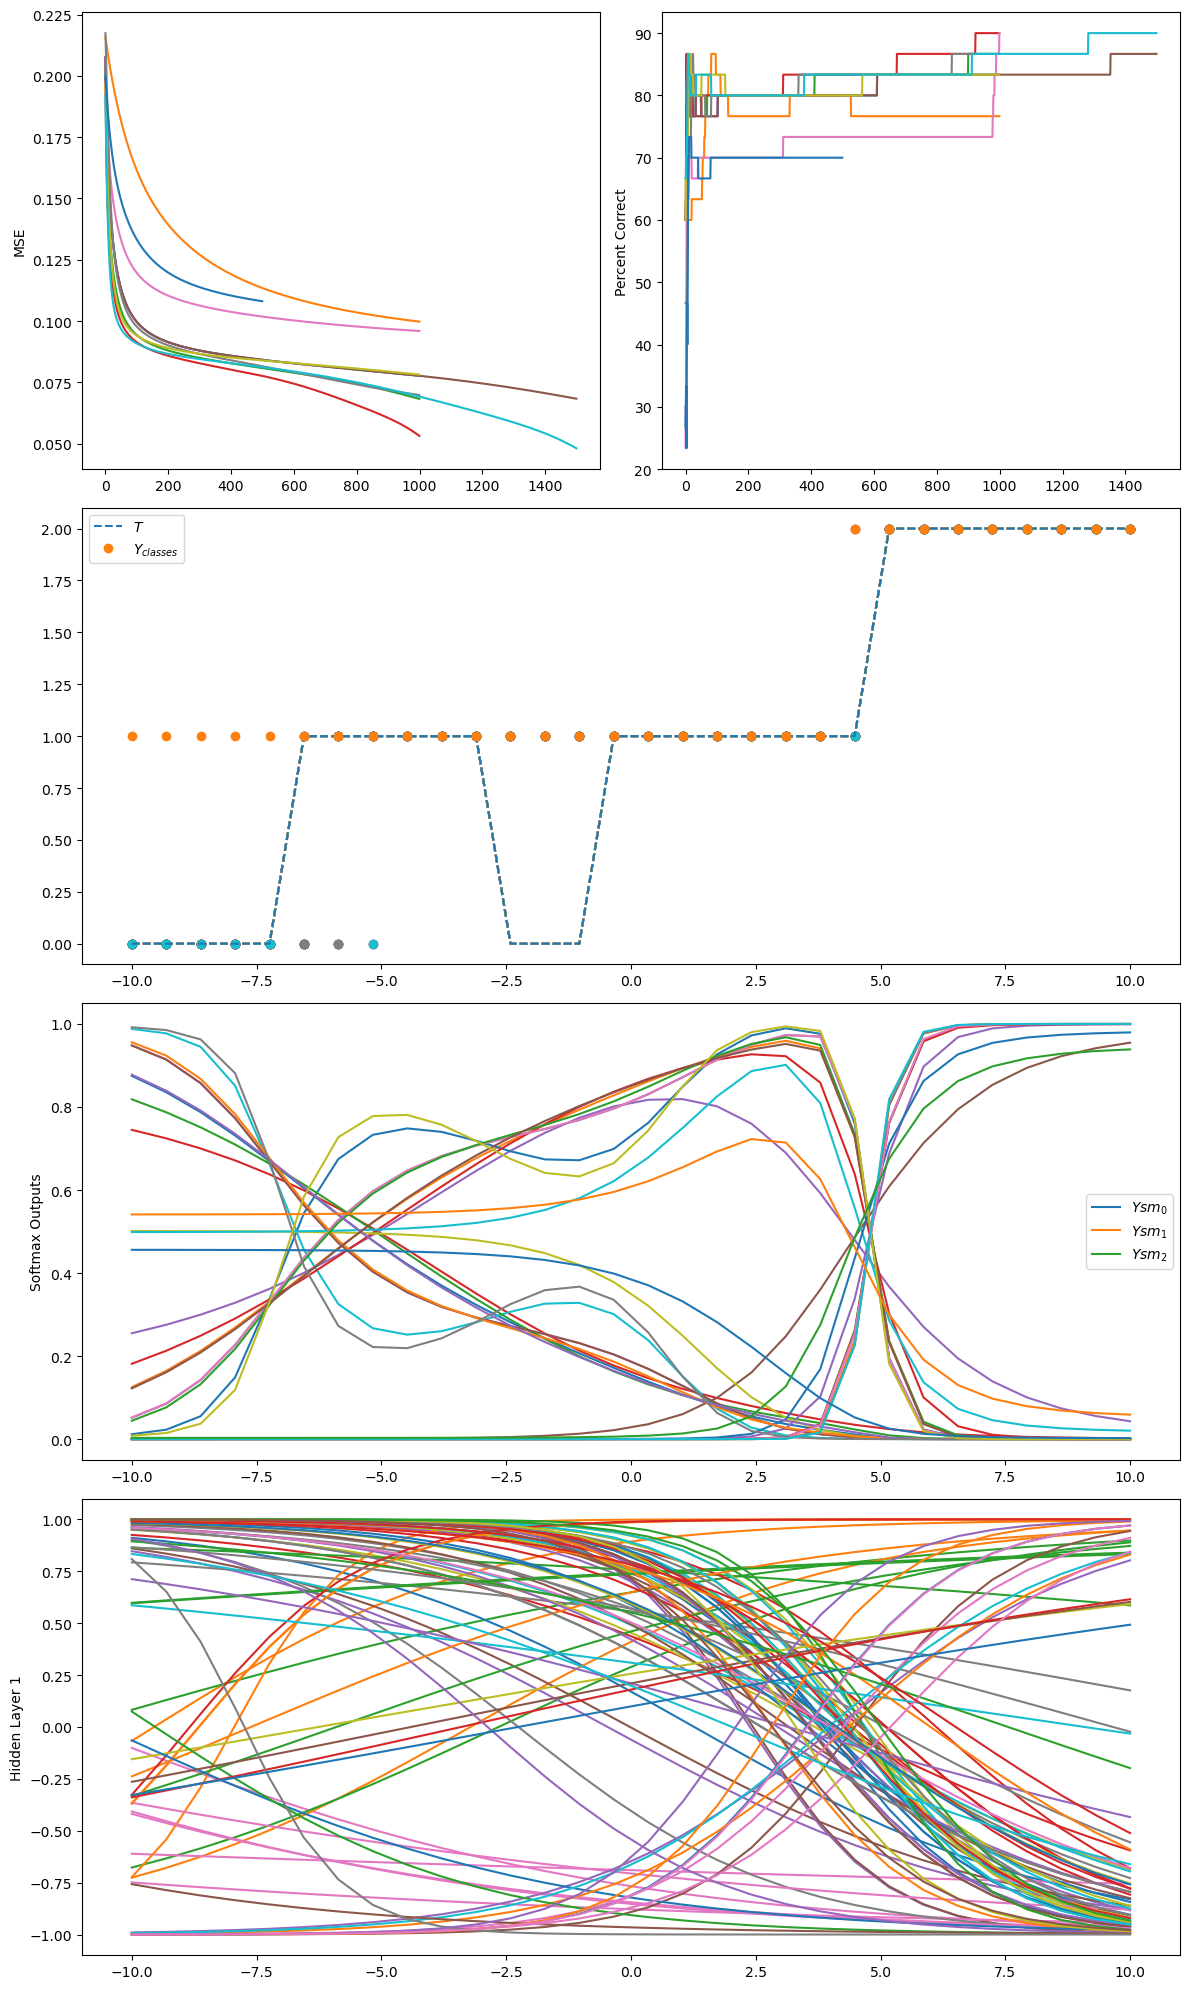

In [82]:
np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [10]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1000
learning_rate = 0.1
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("BASE DATA")
plt.figure(figsize=(12, 20))
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [10]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1000
learning_rate = 0.01
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 1: learning rate = 0.05")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [10]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1000
learning_rate = 0.15
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 2: learning rate = 0.15")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [10]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1000
learning_rate = 0.2
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 3: learning rate = 0.2")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [10]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 500
learning_rate = 0.1
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 4: # of epoch = 500")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [10]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1500
learning_rate = 0.1
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 5: # of epoch = 1500")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [1]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1000
learning_rate = 0.1
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 6: # hidden layers = 1")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [5]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1000
learning_rate = 0.1
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 7: # hidden layers = 5")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [15]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1000
learning_rate = 0.1
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 8: # hidden layers = 15")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)
n_inputs = 1
classes = [0, 1, 2]
hiddens = [15]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 1500
learning_rate = 0.15
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 9: All Parameters increased by 50%")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

np.random.seed(42)

n_inputs = 1
classes = [0, 1, 2]
hiddens = [1]
model = NeuralNetwork(n_inputs, hiddens, classes)

n_epochs = 500
learning_rate = 0.05
model.train(X, T, n_epochs, learning_rate)
Y_classes, Y_softmax = model.use(X)

print("Trial 10: All Parameters decreased by 50%")
print(model.percent_correct(T, Y_classes))
plot_model(model, X, T)

**Test 3 Results:** When the learning rate is increased, the model's percent correct initially improves but eventually starts to fluctuate and then decrease. This is because the learning rate determines how large the updates to the model's weights will be during training, and a very high learning rate can cause the model to overshoot the optimal weights and diverge from the true solution. Similarly, decreasing the learning rate can improve performance by allowing the model to converge more gradually to the optimal weights.

Increasing the number of epochs generally leads to better performance, as the model has more opportunities to update its weights and learn from the data. However, if the number of epochs is too high, the model may start to overfit the training data and perform worse on new data. Decreasing the number of epochs may lead to underfitting and poorer performance.

Finally, to reiterate myself from Test 2. Adding more hidden layers can improve performance by allowing the model to learn more complex features, but too many layers can cause overfitting. On the other hand, decreasing the number of hidden layers may lead to underfitting and poor performance.